# ERASTAR : Interpolation avec le datacube

Après avoir réalisé des tests de colocalisation, nous allons réaliser des interpolations entre les données d'observations et le datacube.

In [1]:
import os
import dask
import intake
import numpy as np
import pandas as pd
import xarray as xr
import dask_jobqueue
import dask.distributed

from pathlib import Path

## Cluster Dask

In [5]:
# Création du cluster Dask
cluster = dask_jobqueue.PBSCluster(queue='omp', 
                                   cores=28,
                                   memory="300GB", # 500GB
                                   walltime="01:00:00",
                                   interface='ib0',
                                   local_directory='/tmp',
                                   log_directory='/home1/scratch/gcaer/dask-logs',
                                   processes=7,
                                  )
cluster.scale(jobs=2)

/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43969 instead
  warnings.warn(


In [6]:
client = dask.distributed.Client(cluster, timeout=600)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.123:43969/status,
Dashboard: http://10.148.1.123:43969/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.123:46645,Workers: 0
Dashboard: http://10.148.1.123:43969/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
port = client.scheduler_info()["services"]["dashboard"]
ssh_command = f'ssh -N -L {port}:{os.environ["HOSTNAME"]}:{port} {os.environ["USER"]}@datarmor.ifremer.fr'

print(f"{ssh_command}")
print(f"open browser at address of the type: http://localhost:{port}")

ssh -N -L 43969:r2i2n25:43969 gcaer@datarmor.ifremer.fr
open browser at address of the type: http://localhost:43969


## Ouverture du datacube

In [9]:
# Chemin vers le datacube
wrk = Path('/home1/datawork/gcaer/data')
name = 'erastar'
version = 'datacube_year'
output = wrk / name / version

In [10]:
%%time
# Ouverture du datacube
start, end = 2018, 2020
chunks = {"time": 1, "latitude": -1, "longitude": -1}
vars = ["es_u10s", "es_v10s", "e5_u10s", "e5_v10s", "count", "quality_flag"]
cat = intake.open_catalog(output / "reference.yaml")
datacubes = [cat[str(year)](chunks=chunks).to_dask().drop_vars(vars) for year in range(start, end+1)]
datacube = xr.concat(datacubes, dim="time")

datacube = (datacube.rename(
            {v: v.replace("tauu", "taue") for v in datacube if "tauu" in v}
        ).rename(
            {v: v.replace("tauv", "taun") for v in datacube if "tauv" in v}
        )
)

/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


CPU times: user 2.15 s, sys: 252 ms, total: 2.4 s
Wall time: 6.5 s


/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


## Ouverture des matchups

In [11]:
# Ouverture des matchups
label = 'gps_Jason-3_2019'
zarr_dir = Path("/home/datawork-lops-osi/aponte/margot/historical_coloc")
ds_raw = xr.open_zarr(zarr_dir / f'{label}.zarr')

## Initialise les matchups

In [12]:
dt = (-12, 13)  # +/- Nombre d'heure à extraire autour des points d'observations (+/- 12 heures)

In [13]:
def initialisation(ds, **kwargs):
    """Inialisation du dataset de matchup, afin de préparer l'étape de pré-traitement."""
    
    # Sélection des matchups avec une distance inférieur à 200km ? 
    ds = ds.where(ds_raw.alti___distance.compute()<2e5, drop=True)
    
    vars = [
        '__site_id','__site_name','alti___distance','alti___source','alti___source_center_index','alti___source_slices',
        'alti___time_difference','alti_cycle','alti_dac','alti_ggx_dac','alti_ggx_internal_tide','alti_ggx_mdt','alti_ggx_ocean_tide',
        'alti_ggx_sla_filtered','alti_ggx_sla_unfiltered','alti_ggx_sla_unfiltered_denoised','alti_ggx_sla_unfiltered_denoised_uncertainty',
        'alti_ggx_sla_unfiltered_imf1','alti_ggx_sla_unfiltered_noise','alti_internal_tide', 'alti_lwe','alti_mdt','alti_ocean_tide',
        'alti_sla_filtered','alti_sla_unfiltered','alti_sla_unfiltered_denoised','alti_sla_unfiltered_denoised_uncertainty','alti_sla_unfiltered_imf1',
        'alti_sla_unfiltered_noise','alti_tpa_correction','alti_track','box_latc','box_lonc','box_phi','box_theta_lat','box_theta_lon',
        'drifter_WMO','drifter_acc_x','drifter_acc_y','drifter_coriolis_x','drifter_coriolis_y','drifter_deploy_date','drifter_deploy_lat',
        'drifter_deploy_lon','drifter_drogue_lost_date','drifter_end_date','drifter_end_lat','drifter_end_lon','drifter_err_lat','drifter_err_lon',
        'drifter_err_ve','drifter_err_vn','drifter_expno','drifter_gap','drifter_lon360','drifter_rowsize','drifter_theta_lat','drifter_theta_lon',
        'drifter_typebuoy','drifter_typedeath','drifter_ve', 'drifter_vn','drifter_vx', 'drifter_vy','f','alti_time_mid', 
        'alti_x','alti_x_mid','alti_y','alti_y_mid']

    # Suppression des variables sans intérets
    ds = ds.drop_vars(vars)

    # Pour chaque observation, définition de l'extension temporelle
    ds['time_min'] = (ds.time + np.timedelta64(kwargs['dt'][0], 'h'))
    ds['time_max'] = (ds.time + np.timedelta64(kwargs['dt'][1]-1, 'h'))
    return ds

## Pré-traitements des matchups

In [14]:
_lon_180_to_360 = lambda lon: lon % 360

def limite_lon(boxs, drifters):
    """ Fonction universel (ufunc) qui créé un mask pour les observations avec une longitude en dehors 
    de la plage [-178:178] """
    limite_lons = []
    for box, drifter in zip(boxs, drifters):
        limite_lon = ((drifter > 178).any() or (drifter < -178).any() or (box > 178).any() or (box < -178).any())
        if limite_lon: 
            limite_lons.append(True)
        else:
            limite_lons.append(False)
    return np.array(limite_lons)

def lon_180_to_360(values, limits):
    """ Fonction universelle (ufunc) qui pour chaque observation, convertis les valeurs de longitudes 
    de la plage [-180:180] à [0:360], si les valeurs de longitude sont en dehors de la plage [-178:178]. """
    new_values = []
    for value, limit in zip(values, limits):
        if limit:
            new_values.append(_lon_180_to_360(value))
        else:
            new_values.append(value)
    return np.array(new_values)

def lon_180_to_360_alti(values, limits, **kwargs):
    """ Fonction universelle (ufunc) qui pour chaque observation, convertis les valeurs de alti_lon 
    de la plage [-180:180] à [0:360], si les valeurs de longitude sont en dehors de la plage [-178:178]. """
    new_values = []
    for value, limit in zip(values, limits):
        if limit:
            new_values.append(_lon_180_to_360(value[kwargs['idx']]))
        else:
            new_values.append(value[kwargs['idx']])
    return np.array(new_values)

def mask_drifter_time(drifter_times, times, **kwargs):
    """ Fonction universelle (ufunc) qui pour chaque observation créé un mask pour les valeurs de drifter_time qui sont
    dans la plage +/- dt jour autour de la valeur de time. """
    values = []
    for drifter_time, time in zip(drifter_times, times):
        t = pd.to_datetime(time)
        start = np.datetime64((t + pd.Timedelta(hours=kwargs['dt'][0])))
        end = np.datetime64((t + pd.Timedelta(hours=kwargs['dt'][1]-1)))
        mask = (drifter_time >= start) & (drifter_time <= end)
        drifter_time[~mask] = np.datetime64('NaT')
        drifter_time.astype(np.int64)
        values.append(drifter_time)
    return np.array(values)

def set_time_array(times, **kwargs):
    """ Fonction universelle (ufunc) qui pour chaque observation, génère une liste de date qui sont dans 
    la plage +/- dt jour autour de la valeur de time. """
    values = []
    for time in zip(times):
        t = pd.to_datetime(time)
        t = [np.datetime64((t + pd.Timedelta(hours=_dt)).date[0]) for _dt in range(*kwargs['dt'])]
        values.append(t)
    return np.array(values).astype(np.int64)
    
def min_apply(boxs, drifters):
    """ Fonction universelle (ufunc) qui pour chaque observation recupère la valeur minimale de longitude/latitude entre box et drifter. """
    return np.array([min(box.min(), drifter.min()) for box, drifter in zip(boxs, drifters)])

def max_apply(boxs, drifters):
    """ Fonction universelle (ufunc) qui pour chaque observation recupère la valeur maximale de longitude/latitude entre box et drifter. """
    return np.array([max(box.max(), drifter.max()) for box, drifter in zip(boxs, drifters)])

In [15]:
def set_limite_lon(ds):
    # Créé un mask des observation avec une valeur de longitude (box_lon, drifter_lon) en dehors de la plage [-178:178]
    ds['limite_lon'] = xr.apply_ufunc(
        limite_lon, 
        ds["box_lon"], 
        ds["drifter_lon"],
        input_core_dims=[['box_x', 'box_y'], ['site_obs']],
        output_core_dims=[[]],
        output_dtypes=[bool],
        dask='parallelized'
    )
    return ds

def set_new_box_lon(ds):
    # Conversion des valeurs de box_lon de la plage [-180:180] à [0:360] pour les observations dont limite_lon = True
    ds['new_box_lon'] = xr.apply_ufunc(
        lon_180_to_360, 
        ds["box_lon"], 
        ds["limite_lon"],
        input_core_dims=[['box_y', 'box_x'], []],
        output_core_dims=[['box_y', 'box_x']],
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={'box_y':80, 'box_x':120}),
        dask='parallelized'
    )
    return ds

def set_new_drifter_lon(ds):
    # Conversion des valeurs de drifter_lon de la plage [-180:180] à [0:360] pour les observations dont limite_lon = True
    ds['new_drifter_lon'] = xr.apply_ufunc(
        lon_180_to_360, 
        ds["drifter_lon"], 
        ds["limite_lon"],
        input_core_dims=[['site_obs'], []],
        output_core_dims=[['site_obs']],
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={'site_obs': ds.sizes['site_obs']}),
        dask='parallelized'
    )
    return ds

def set_new_alti_lon(ds):
    # Conversion des valeurs de alti_lon de la plage [-180:180] à [0:360] pour les observations dont limite_lon = True
    ds['new_alti_lon'] = xr.apply_ufunc(
        lon_180_to_360_alti, 
        ds["alti_lon"], 
        ds["limite_lon"],
        input_core_dims=[['alti_time'], []],
        output_core_dims=[[]],
        output_dtypes=[float],
        dask='parallelized',
        kwargs={'idx': ds.sizes['alti_time']//2}
    )
    return ds

def set_new_drifter_time(ds, dt):
    # Sélection des valeurs de drifter_time qui sont dans la plage +/- dt jour autour de la valeur de time.
    ds['new_drifter_time'] = xr.apply_ufunc(
        mask_drifter_time, 
        ds["drifter_time"].chunk(dict(site_obs=-1)), 
        ds["time"],
        input_core_dims=[['site_obs'], []],
        output_core_dims=[['site_obs']],
        output_dtypes=[int],
        dask_gufunc_kwargs=dict(output_sizes={'site_obs': ds.sizes['site_obs']}),
        dask='parallelized',
        kwargs={'dt': dt} # +/- 2 jours
    ).astype('datetime64[ns]')
    return ds

def set_new_drifter_time_array(ds, dt):
    # Création d'une liste de date qui sont dans la plage +/- dt jour autour de la valeur de time.
    ds['_drifter_time_array'] = xr.apply_ufunc(
        set_time_array, 
        ds["time"],
        input_core_dims=[[]],
        output_core_dims=[['t']],
        output_dtypes=[int],
        dask_gufunc_kwargs=dict(output_sizes={'t': len(range(*dt))}),
        dask='parallelized',
        kwargs={'dt': dt} # +/- 2 jours
    ).astype('datetime64[ns]')
    return ds

def set_matchup_site(ds):
    # Récupération des valeurs de longitude, latitude et temps des bouées dérivantes
    ds_obs_m = ds.isel(site_obs=xr.DataArray(ds.__site_matchup_indice.values.astype(int), dims='obs'))
    ds['_drifter_lon'] = ds_obs_m['new_drifter_lon']
    ds['_drifter_lat'] = ds_obs_m['drifter_lat']
    ds['_drifter_time'] = ds_obs_m['drifter_time']
    return ds

def set_lon_min(ds):
    # Récupère la valeur de longitude minimale entre new_box_lon et new_drifter_lon
    ds['lon_min'] = xr.apply_ufunc(
        min_apply, 
        ds["new_box_lon"], 
        ds["new_drifter_lon"],
        input_core_dims=[['box_y', 'box_x'], ['site_obs']],
        output_core_dims=[[]],
        output_dtypes=[float],
        dask='parallelized',
    )
    return ds

def set_lon_max(ds):
    # Récupère la valeur de longitude maximale entre new_box_lon et new_drifter_lon
    ds['lon_max'] = xr.apply_ufunc(
        max_apply, 
        ds["new_box_lon"], 
        ds["new_drifter_lon"],
        input_core_dims=[['box_y', 'box_x'], ['site_obs']],
        output_core_dims=[[]],
        output_dtypes=[float],
        dask='parallelized',
    )
    return ds

def set_lat_min(ds):
    # Récupère la valeur de latitude minimale entre new_box_lat et new_drifter_lat
    ds['lat_min'] = xr.apply_ufunc(
        min_apply, 
        ds["box_lat"], 
        ds["drifter_lat"],
        input_core_dims=[['box_y', 'box_x'], ['site_obs']],
        output_core_dims=[[]],
        output_dtypes=[float],
        dask='parallelized',
    )
    return ds

def set_lat_max(ds):
    # Récupère la valeur de latitude maximale entre new_box_lat et new_drifter_lat
    ds['lat_max'] = xr.apply_ufunc(
        max_apply, 
        ds["box_lat"], 
        ds["drifter_lat"],
        input_core_dims=[['box_y', 'box_x'], ['site_obs']],
        output_core_dims=[[]],
        output_dtypes=[float],
        dask='parallelized',
    )
    return ds

In [16]:
def interp_traj(datacube, ds):
    # DRIFTER TRAJECTORY
    res_traj = (
        datacube
        .interp(
            time=ds.new_drifter_time,
            lon=ds['new_drifter_lon'],
            lat=ds['drifter_lat'],
            )
        .rename({v: "es_traj_" + v for v in datacube})
        .drop_vars(
            [
                "drifter_lon",
                "drifter_lat",
                "lon",
                "lat",
                "time",
            ]
        )
    )
    return res_traj

def interp_box(datacube, ds):
    # BOX
    res_box = (
        datacube
        .interp(
            time=ds._drifter_time,
            lon=ds.new_box_lon,
            lat=ds.box_lat,
        )
        .drop_vars(["lat", "lon", "time"])
        .rename({v: "es_box_" + v for v in datacube})
    )
    return res_box

def interp_drifter(datacube, ds):
    # DRIFTER MATCHUP POSITION
    res_drifter = (
        datacube
        .interp(
            time=ds['_drifter_time_array'],
            lon=ds['_drifter_lon'],
            lat=ds['_drifter_lat'],
        )
    )
    res_drifter['es_time_'] = ds['_drifter_time_array']
    res_drifter = (
        res_drifter.set_coords(['es_time_'])
        .drop_vars(["lat", "lon", "time"])
        .rename({v: "es_drifter_temp_" + v for v in datacube})
        .rename({'t': 'es_time'})
    )
    return res_drifter

def interp_alti(datacube, ds):
    # ALTI
    res_alti = (
        datacube
        .interp(
            time=ds['alti_time_'].isel(alti_time=ds.sizes['alti_time']//2),
            lon=ds['new_alti_lon'],
            lat=ds['alti_lat'].isel(alti_time=ds.sizes['alti_time']//2),
        )
    )
    res_alti = res_alti.drop_vars(list(res_alti.coords.keys())).rename(
        {v: "es_alti_matchup_" + v for v in datacube}
    )
    return res_alti

def merge_results(ds, res_traj, res_box, res_drifter, res_alti):
    res_drifter_matchup = (
        res_traj.isel(site_obs=xr.DataArray(ds.__site_matchup_indice.values.astype(int), dims='obs'))
        .drop_vars(list(res_traj.coords.keys()))
        .rename({v: v.replace("traj_", "drifter_matchup_") for v in res_traj})
    )

    res = (
        xr.merge([res_traj, res_drifter_matchup, res_box, res_drifter, res_alti])
            .reset_coords(["drifter_time", "drifter_x", "drifter_y", "es_time_"])
    )

    res = res.set_coords(
            ["obs", "es_time_"]
        )

    res = res.rename({v: "es_" + v.replace("es_", "") for v in res if "es_" in v})
    res = res.rename({v: "e5_" + v.replace("es_", "").replace("e5_", "") for v in res if "e5_" in v})
    return res

def set_attrs(res):
    
    # attrs
    res.e5_alti_matchup_taue.attrs = {
        "long_name": "era5 eastward wind stress interpolated on the altimeter's matchup",
        "units": "Pa",
    }
    res.e5_alti_matchup_taun.attrs = {
        "long_name": "era5 northward wind stress interpolated on the altimeter's matchup",
        "units": "Pa",
    }
    
    res.e5_drifter_matchup_taue.attrs = {
        "long_name": "era5 eastward wind stress interpolated on the drifter's matchup",
        "units": "Pa",
    }
    res.e5_drifter_matchup_taun.attrs = {
        "long_name": "era5 northward wind stress interpolated on the drifter's matchup",
        "units": "Pa",
    }
    
    res.e5_box_taue.attrs = {
        "long_name": "era5 eastward wind stress interpolated on the box at the matchup time or several times (depending on the dimension)",
        "units": "Pa",
    }
    res.e5_box_taun.attrs = {
        "long_name": "era5 northward wind stress interpolated on the box at the matchup time or several times (depending on the dimension)",
        "units": "Pa",
    }
    
    res.e5_drifter_temp_taue.attrs = {
        "long_name": "era5 eastward wind stress interpolated on the drifter's matchup position for several times (static but temporal variation)",
        "units": "Pa",
    }
    res.e5_drifter_temp_taun.attrs = {
        "long_name": "era5 northward wind stress interpolated on the drifter's matchup position for several times (static but temporal variation)",
        "units": "Pa",
    }
    
    res.e5_traj_taue.attrs = {
        "long_name": "era5 eastward wind stress interpolated on the drifter's trajectory",
        "units": "Pa",
    }
    res.e5_traj_taun.attrs = {
        "long_name": "era5 northward wind stress interpolated on the drifter's trajectory",
        "units": "Pa",
    }
    
    res.es_alti_matchup_taue.attrs = {
        "long_name": "erastar eastward wind stress interpolated on the altimeter's matchup",
        "units": "Pa",
    }
    res.es_alti_matchup_taun.attrs = {
        "long_name": "erastar northward wind stress interpolated on the altimeter's matchup",
        "units": "Pa",
    }
    
    res.es_drifter_matchup_taue.attrs = {
        "long_name": "erastar eastward wind stress interpolated on the drifter's matchup",
        "units": "Pa",
    }
    res.es_drifter_matchup_taun.attrs = {
        "long_name": "erastar northward wind stress interpolated on the drifter's matchup",
        "units": "Pa",
    }
    
    res.es_box_taue.attrs = {
        "long_name": "erastar eastward wind stress interpolated on the box at the matchup time",
        "units": "Pa",
    }
    res.es_box_taun.attrs = {
        "long_name": "erastar northward wind stress interpolated on the box at the matchup time",
        "units": "Pa",
    }
    
    res.es_drifter_temp_taue.attrs = {
        "long_name": "erastar eastward wind stress interpolated on the drifter's matchup position for several times (static but temporal variation)",
        "units": "Pa",
    }
    res.es_drifter_temp_taun.attrs = {
        "long_name": "erastar northward wind stress interpolated on the drifter's matchup position for several times (static but temporal variation)",
        "units": "Pa",
    }
    
    res.es_traj_taue.attrs = {
        "long_name": "erastar eastward wind stress interpolated on the drifter's trajectory",
        "units": "Pa",
    }
    res.es_traj_taun.attrs = {
        "long_name": "erastar northward wind stress interpolated on the drifter's trajectory",
        "units": "Pa",
    }
    
    return res

In [17]:
def interpolation(datacube, ds, is_360=False):
    """Interpolation avec le datacube"""
    _lon_180_to_360 = lambda lon: lon % 360
    
    if is_360 == True:
        datacube = datacube.assign_coords(lon=_lon_180_to_360(datacube.lon))
        datacube = datacube.sortby("lon")    
    
    res_traj = interp_traj(datacube, ds)
    res_box = interp_box(datacube, ds)
    res_drifter = interp_drifter(datacube, ds)
    res_alti = interp_alti(datacube, ds)
    res = merge_results(ds, res_traj, res_box, res_drifter, res_alti)
    res = set_attrs(res)
    return res

In [18]:
def preprocessing(ds, dt):
    """Pré-traitement du dataset des matchups"""
    # Preprocessing des données d'observations
    ds = set_limite_lon(ds)
    ds = set_new_box_lon(ds)
    ds = set_new_drifter_lon(ds)
    ds = set_new_alti_lon(ds)
    ds = set_new_drifter_time(ds, dt)
    ds = set_new_drifter_time_array(ds, dt)
    ds = set_matchup_site(ds)
    ds = set_lon_min(ds)
    ds = set_lon_max(ds)
    ds = set_lat_min(ds)
    ds = set_lat_max(ds)
    return ds

In [19]:
@dask.delayed
def processing(ds, datacube, dt):
    """Traitement entre les données du dataset des matchups et le datacube, 
    avec interpolation selon limite_lon = True or False et concaténation"""
    # Préparation des points d'observations (preprocessing)
    ds = preprocessing(ds, dt=dt)

    # Séparation des points avec limite_lon True or False (car traitement différents)
    ds_180 = ds.where(ds.limite_lon.compute() == False, drop=True)
    ds_360 = ds.where(ds.limite_lon.compute() == True, drop=True)

    # Interpolations et traitements
    res_180 = interpolation(datacube, ds_180)
    res_360 = interpolation(datacube, ds_360, is_360=True)

    # Concaténation des résultats pour limite_lon True or False
    res = xr.merge([res_180, res_360])

    return res

In [20]:
@dask.delayed
def concat(i, results, output, filename):
    """Concaténation des batches, et sauvegarde sur disque"""
    r = dask.compute(*results)
    res = xr.concat(r, "obs")
    
    res.to_netcdf(output / f'{filename}_{i}.nc')

In [21]:
def conf(ds, n_obs, n_batch):
    """Visualisation des paramètres (nombre de fichiers de sorties, ..) en fonction de la configuration d'entrée"""
    n_batches = ds.sizes['obs']//n_obs + 1 # Nombre de batch au total
    n_netcdf = n_batches//n_batch + 1 # Nombre de fichier netCDF en sortie
    print(f"Nombre d'observation par batch: {n_obs}")
    print(f"Nombre de batch: {n_batches}")
    print(f"Nombre de batch par fichier netCDF: {n_batch}")
    print(f"Nombre de fichier NetCDF: {n_netcdf}")
    print(f"Nombre d'observations par fichier NetCDF: {n_obs*n_batch}")

In [22]:
def recipe(ds, datacube, dt, n_obs, n_batch, output, filename):
    """Création des recettes en lazy_mode
    n_obs : Nombre d'observation par batch
    n_batch : Nombre de batch par fichier netCDF
    """

    batches = []
    n_batches= ds.sizes['obs']//n_obs + 1
    for i in range(n_batches):
        # Sélection des observation dans la tranche
        ds_sub = ds.isel(obs=slice(i*n_obs, (i+1)*n_obs))
        time_min, time_max = ds_sub.time_min.values.min(), ds_sub.time_max.values.max()
        # Sélection de la portion du datacube concerné par la tranche
        datacube_sub = datacube.sel(time=slice(time_min, time_max))
        batches.append(processing(ds_sub, datacube_sub, dt))

    n_netcdf = len(batches)//n_batch + 1 # Nombre de fichier netCDF en sortie
    concats = []
    for i in range(n_netcdf):
        r = batches[slice(i*n_batch, (i+1)*n_batch)]
        concats.append(concat(i, r, output, filename))
    return concats

In [23]:
%%time
# Initialisation des matchups
ds = initialisation(ds_raw, dt=dt)

CPU times: user 5.67 s, sys: 296 ms, total: 5.97 s
Wall time: 33.8 s


In [29]:
n_obs = 500 # Nombre d'observation à traiter en même temps (Nombre d'observation dans un batch)
n_batch = 4 # Nombre de batch par fichier netCDF

In [30]:
# Visualisation des paramètres de configuration
conf(ds, n_obs, n_batch)

Nombre d'observation par batch: 500
Nombre de batch: 284
Nombre de batch par fichier netCDF: 4
Nombre de fichier NetCDF: 72
Nombre d'observations par fichier NetCDF: 2000


In [31]:
%%time
path = Path('/home1/scratch/gcaer/data/erastar')
filename = f"{label}_interp"
concats = recipe(ds, datacube, dt, n_obs, n_batch, path, filename)

CPU times: user 4.04 s, sys: 76 ms, total: 4.12 s
Wall time: 4.06 s


In [32]:
len(concats)

72

In [33]:
%%time
z = dask.compute(concats[:2])

/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 16.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 1min 5s, sys: 6.03 s, total: 1min 11s
Wall time: 7min 36s


## Analyse des résultats

In [34]:
n = 0 # Numéro de fichier
res = xr.open_dataset(path / f'{filename}_{n}.nc')

In [35]:
res

<xarray.Dataset>
Dimensions:                  (obs: 2000, box_x: 120, box_y: 80, site_obs: 1489,
                              es_time: 25)
Coordinates:
  * obs                      (obs) int64 1 2 3 4 5 ... 2324 2325 2326 2327 2329
  * box_x                    (box_x) float64 -3e+05 -2.95e+05 ... 2.95e+05
  * box_y                    (box_y) float64 -2e+05 -1.95e+05 ... 1.95e+05
    es_time_                 (obs, es_time) datetime64[ns] ...
Dimensions without coordinates: site_obs, es_time
Data variables: (12/23)
    e5_traj_taue             (obs, site_obs) float64 ...
    e5_traj_taun             (obs, site_obs) float64 ...
    es_traj_taue             (obs, site_obs) float64 ...
    es_traj_taun             (obs, site_obs) float64 ...
    drifter_time             (obs, site_obs) datetime64[ns] ...
    drifter_x                (obs, site_obs) float64 ...
    ...                       ...
    es_drifter_temp_taue     (obs, es_time) float64 ...
    es_drifter_temp_taun     (obs, es_time) float64 ...
    e5_alti_matchup_taue     (obs) float64 ...
    e5_alti_matchup_taun     (obs) float64 ...
    es_alti_matchup_taue     (obs) float64 ...
    es_alti_matchup_taun     (obs) float64 ...
Attributes: (12/55)
    Conventions:                 CF-1.7, ACDD-1.3, ISO 8601
    Metadata_Conventions:        Climate and Forecast (CF) 1.7, Attribute Con...
    acknowledgement:             Please acknowledge the use of these data wit...
    band:                        C, C, Ku
    cdm_data_type:               grid
    comment:                     These data were produced at ICM/CSIC as part...
    ...                          ...
    summary:                     This data set contains the stress equivalent...
    technical_support_contact:   cersat@ifremer.fr
    time_coverage_end:           20180101T00:00:00
    time_coverage_start:         20180101T00:00:00
    title:                       hourly stress equivalent model wind componen...
    track_id:                    5c0cb21b-ddb0-4e35-b5cf-c6acfd73fd6d

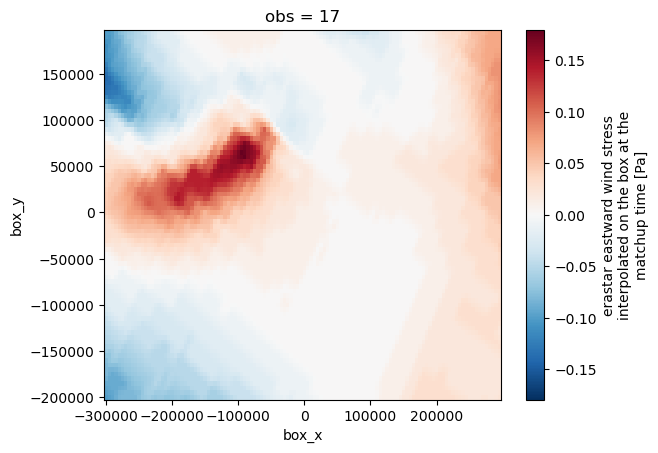

In [36]:
n_obs = 12 # 4 pour avoir NaN, 12 pour avoir limite_lon avec label = 'gps_Jason-3_2019'
obs = res.isel(obs=n_obs)
obs.es_box_taue.plot()

In [37]:
# Calculer la taille en mémoire de chaque variable
tailles_variables = {var: res[var].nbytes for var in res.variables}

# Calculer la taille totale du dataset
taille_totale = sum(tailles_variables.values())

print("Tailles des variables individuelles :")
for var, taille in tailles_variables.items():
    print(f"{var}: {taille} bytes")

print(f"Taille totale du dataset : {taille_totale} bytes")
print(f"Taille totale du dataset : {taille_totale / (1024 ** 3)} Go")

Tailles des variables individuelles :
obs: 16000 bytes
box_x: 960 bytes
box_y: 640 bytes
e5_traj_taue: 23824000 bytes
e5_traj_taun: 23824000 bytes
es_traj_taue: 23824000 bytes
es_traj_taun: 23824000 bytes
drifter_time: 23824000 bytes
drifter_x: 23824000 bytes
drifter_y: 23824000 bytes
e5_drifter_matchup_taue: 16000 bytes
e5_drifter_matchup_taun: 16000 bytes
es_drifter_matchup_taue: 16000 bytes
es_drifter_matchup_taun: 16000 bytes
e5_box_taue: 153600000 bytes
e5_box_taun: 153600000 bytes
es_box_taue: 153600000 bytes
es_box_taun: 153600000 bytes
e5_drifter_temp_taue: 400000 bytes
e5_drifter_temp_taun: 400000 bytes
es_drifter_temp_taue: 400000 bytes
es_drifter_temp_taun: 400000 bytes
es_time_: 400000 bytes
e5_alti_matchup_taue: 16000 bytes
e5_alti_matchup_taun: 16000 bytes
es_alti_matchup_taue: 16000 bytes
es_alti_matchup_taun: 16000 bytes
Taille totale du dataset : 783313600 bytes
Taille totale du dataset : 0.7295176386833191 Go
